# Fashion MNIST
This notebook will guide you through the use of the `keras` package to train convolutional neural networks for handwritten digits classification. You are going to use the `mnist` dataset from LeCun et al. 1998.

## Loading the packages

In [1]:
import numpy as np
from keras.callbacks import ReduceLROnPlateau
from keras.datasets import fashion_mnist
from keras.layers import Input, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Dense, Flatten
from keras.models import Model, Sequential
from keras.optimizers import RMSprop
from keras.utils import np_utils, plot_model
from matplotlib import pyplot as pl
from sklearn import metrics as me

from utils import plot_confusion_matrix

%matplotlib inline

2023-04-30 19:32:00.546579: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-30 19:32:00.979112: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


First, create some useful functions

In [2]:
def build_grid_of_images(array):
    assert len(array.shape) == 3
    dim_0 = np.sqrt(array.shape[0])
    assert dim_0.is_integer()

    temp_out = np.reshape(array, (dim_0, dim_0, array.shape[1], array.shape[2]))
    temp_out = np.rollaxis(temp_out, 1, 3)
    return np.reshape(temp_out, (dim_0 * array.shape[1], dim_0 * array.shape[2]))


def plot_conv_layer_output(temp_out, title):
    temp_to_plot = build_grid_of_images(temp_out)
    pl.imshow(temp_to_plot, interpolation='nearest', cmap=pl.get_cmap('Greys'))
    ax = pl.gca()
    ax.set_xticks(np.arange(-0.5, temp_to_plot.shape[0] + 0.5, temp_out.shape[1]))
    ax.set_yticks(np.arange(-0.5, temp_to_plot.shape[0] + 0.5, temp_out.shape[2]))
    pl.grid()
    pl.tick_params(axis='both', which='both',
                   bottom='off', top='off', left='off', right='off',
                   labelbottom='off', labelleft='off')
    pl.title(title)


def plot_dense_layer_output(temp_out, title):
    pl.bar(np.arange(temp_out.shape[1]) - 0.4, temp_out[0, :])
    pl.xlim(-0.5, temp_out.shape[1])
    pl.grid()
    pl.title(title)

Load the `mnist` dataset and normalize in the range [0, 1]

In [3]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

n_train, height, width = X_train.shape
n_test, _, _ = X_test.shape

X_train = X_train.reshape(n_train, height, width, 1).astype('float32')
X_test = X_test.reshape(n_test, height, width, 1).astype('float32')

X_train /= 255.0
X_test /= 255.0

n_classes = 10

print(n_train, 'train samples')
print(n_test, 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)

60000 train samples
10000 test samples


In [4]:
print('X_train.shape = ', X_train.shape)
print('Y_train.shape = ', Y_train.shape)
print('X_test.shape = ', X_test.shape)
print('Y_test.shape = ', Y_test.shape)

X_train.shape =  (60000, 28, 28, 1)
Y_train.shape =  (60000, 10)
X_test.shape =  (10000, 28, 28, 1)
Y_test.shape =  (10000, 10)


Create the CNN and show its architecture

In [5]:
model = Sequential([
    Input((height, width, 1), name='l0'),
    
    Conv2D(32, (3, 3), activation='relu', padding='same', name='l1'),
    MaxPooling2D((2, 2), name='l1_mp'),
    Dropout(0.15, name='l1_drop'),
    
    Conv2D(64, (3, 3), activation='relu', padding='same', name='l2'),
    MaxPooling2D((2, 2), name='l2_mp'),
    Dropout(0.2, name='l2_drop'),

    Flatten(name='flat'),
    Dropout(0.4, name='flat_drop'),
    
    Dense(128, activation='relu', name='l3'),
    Dropout(0.15, name='l3_drop'),
    
    Dense(n_classes, activation='softmax', name='l4'),
])

callbacks = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=2,
        min_lr=0.00000001
    ),
]

2023-04-30 19:32:05.371474: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0c:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-30 19:32:05.381965: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0c:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-30 19:32:05.382013: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0c:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-30 19:32:05.383773: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0c:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-30 19:32:05.383815: I tensorflow/compile

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 l1 (Conv2D)                 (None, 28, 28, 32)        320       
                                                                 
 l1_mp (MaxPooling2D)        (None, 14, 14, 32)        0         
                                                                 
 l1_drop (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 l2 (Conv2D)                 (None, 14, 14, 64)        18496     
                                                                 
 l2_mp (MaxPooling2D)        (None, 7, 7, 64)          0         
                                                                 
 l2_drop (Dropout)           (None, 7, 7, 64)          0         
                                                                 
 flat (Flatten)              (None, 3136)              0

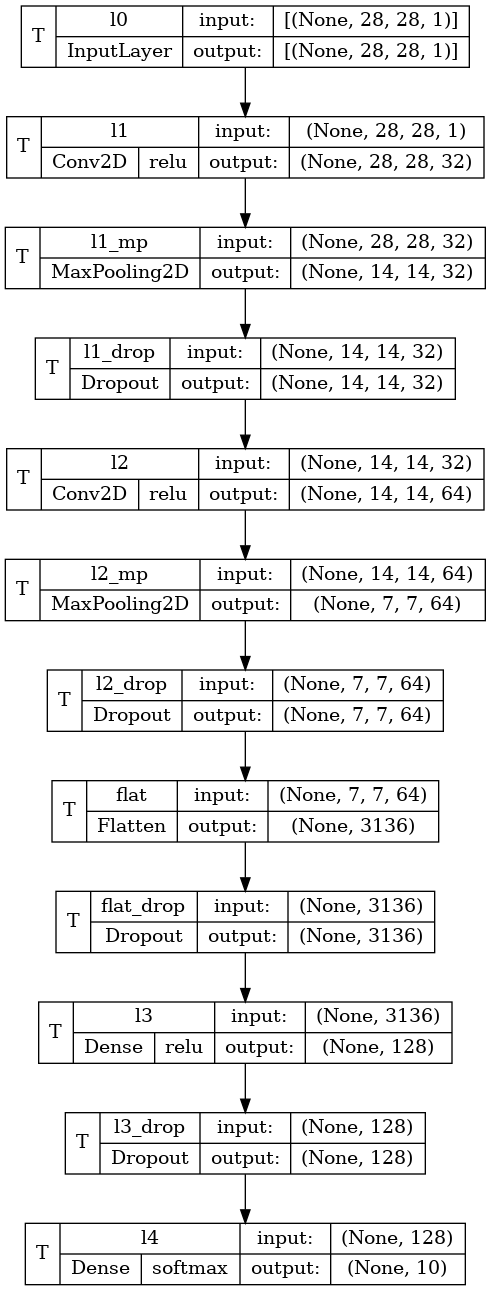

In [7]:
plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
    show_layer_activations=True,
    show_trainable=True,
    to_file='fashion_mnist-model.png'
)

Define some constants and train the CNN

In [8]:
batch_size = 128
n_epoch = 25

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])
history = model.fit(X_train, Y_train, callbacks=callbacks, batch_size=batch_size, epochs=n_epoch, verbose=1, validation_split=0.1)

Epoch 1/25


2023-04-28 13:53:49.311760: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/l1_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-04-28 13:53:50.267303: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-04-28 13:53:51.397996: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


422/422 [==============================] - 6s 9ms/step - loss: 0.5798 - accuracy: 0.7874 - val_loss: 0.3914 - val_accuracy: 0.8555 - lr: 0.0010
Epoch 2/25
422/422 [==============================] - 4s 8ms/step - loss: 0.3709 - accuracy: 0.8668 - val_loss: 0.3149 - val_accuracy: 0.8860 - lr: 0.0010
Epoch 3/25
422/422 [==============================] - 4s 9ms/step - loss: 0.3225 - accuracy: 0.8844 - val_loss: 0.2830 - val_accuracy: 0.8988 - lr: 0.0010
Epoch 4/25
422/422 [==============================] - 4s 9ms/step - loss: 0.2945 - accuracy: 0.8915 - val_loss: 0.2629 - val_accuracy: 0.9033 - lr: 0.0010
Epoch 5/25
422/422 [==============================] - 4s 9ms/step - loss: 0.2756 - accuracy: 0.9004 - val_loss: 0.2401 - val_accuracy: 0.9140 - lr: 0.0010
Epoch 6/25
422/422 [==============================] - 4s 9ms/step - loss: 0.2637 - accuracy: 0.9032 - val_loss: 0.2373 - val_accuracy: 0.9132 - lr: 0.0010
Epoch 7/25
422/422 [==============================] - 4s 10ms/step - loss: 0.2541

Show the performance of the model

Test score: 0.21167421340942383
Test accuracy: 0.9258000254631042


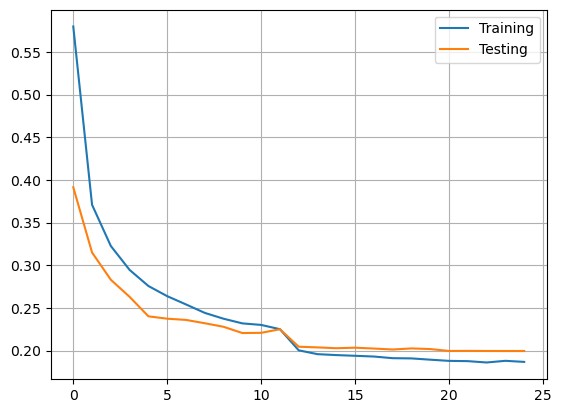

In [9]:
pl.plot(history.history['loss'], label='Training')
pl.plot(history.history['val_loss'], label='Testing')
pl.legend()
pl.grid()

score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Confusion matrix

2023-04-28 13:55:32.438217: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [10000,28,28,1]
	 [[{{node Placeholder/_0}}]]


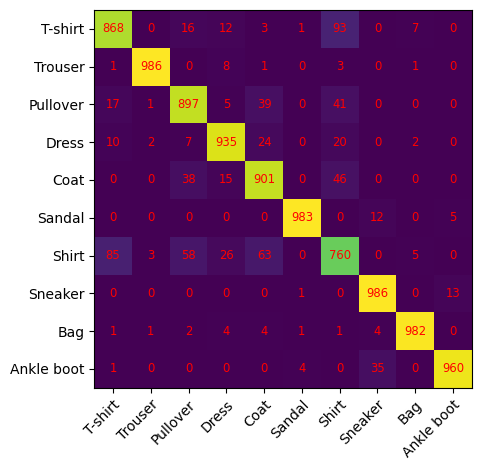

F-score T-shirt: 0.8754412506303582
F-score Trouser: 0.9894631209232314
F-score Pullover: 0.8889990089197226
F-score Dress: 0.9326683291770573
F-score Coat: 0.8855036855036854
F-score Sandal: 0.9879396984924623
F-score Shirt: 0.7739307535641547
F-score Sneaker: 0.9680903289150711
F-score Bag: 0.9834752128192289
F-score Ankle boot: 0.9706774519716885


In [10]:
pred = np.argmax(model.predict_on_batch(X_test), axis=-1)
cm = me.confusion_matrix(y_test, pred)

plot_confusion_matrix(cm, [
    'T-shirt',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot',
], True)